In [ ]:
!curl --header "Host: storage.googleapis.com" --header "User-Agent: Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/89.0.4389.128 Safari/537.36 Edg/89.0.774.77" --header "Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9" --header "Accept-Language: en-US,en;q=0.9" --header "Referer: https://github.com/google-research-datasets/dakshina" "https://storage.googleapis.com/gresearch/dakshina/dakshina_dataset_v1.0.tar" -L -o "dakshina_dataset_v1.0.tar"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1915M  100 1915M    0     0  72.3M      0  0:00:26  0:00:26 --:--:-- 75.9M


In [ ]:
import shutil
shutil.unpack_archive("/content/dakshina_dataset_v1.0.tar",'/content/')

In [ ]:
import re
from tqdm import tqdm
import pandas as pd
import numpy as np
import tensorflow as tf
from keras.models import Sequential,Model,load_model
from keras.layers import Dense,LSTM,GRU,SimpleRNN,Input,Dropout,TimeDistributed,RepeatVector,dot,BatchNormalization,concatenate,multiply,Activation
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence

In [ ]:
class Word_Accuracy_Callback(tf.keras.callbacks.Callback):
  def __init__(self,obj):
    self.obj = obj

  def on_epoch_end(self,epoch,logs):
    count = 0
    for i in range(self.obj.encoder_cv.shape[0]):
      pred = self.model([np.expand_dims(self.obj.encoder_cv[i],0),np.expand_dims(self.obj.decoder_cv[i],0)])
      actual_out = re.sub('\t|\n','',''.join([self.obj.inv_target_token_index[self.obj.decoder_cv[i][j]] for j in range(self.obj.max_length_y)]))
      predicted_out = re.sub('\t|\n','',''.join(self.obj.inv_target_token_index[np.argmax(pred[0][j])] for j in range(self.obj.max_length_y)))
      if (actual_out==predicted_out):
        count+=1

    logs["validation accuracy"] = count/self.obj.encoder_cv.shape[0]
    print("vallidation accuracy =", count/self.obj.encoder_cv.shape[0])

In [ ]:
class seq2seq:
    def __init__(self,cell,embedding_size,latent_dim,encoder_layers_size,decoder_layers_size,dropouts,epochs,batch_size):
        self.cell = cell
        self.embedding_size = embedding_size
        self.latent_dim = latent_dim
        self.encoder_layers_size = encoder_layers_size
        self.decoder_layers_size = decoder_layers_size
        self.dropouts=dropouts
        self.epochs=epochs
        self.batch_size=batch_size

    def get_data(self,path):
        d = pd.read_csv(path,sep="\t",header=None,error_bad_lines=False)
        d = d.dropna()

        decoder_target_data = np.zeros((d.shape[0],self.max_length_y,self.decoder_tokens), dtype="float32")

        for i,target_text in enumerate(d[0]):
            target_text = '\t'+target_text+'\n'
            for t, char in enumerate(target_text):
                if t > 0:
                    decoder_target_data[i, t - 1, self.target_token_index[char]] = 1.0
            decoder_target_data[i, t:, self.target_token_index["\n"]] = 1.0

        return ([[self.input_token_index[letter] for letter in list('\t'+word+'\n')] for word in d[1]]),\
                ([[self.target_token_index[letter] for letter in list('\t'+word+'\n')] for word in d[0]]),decoder_target_data

    def create_vocab(self,path):
        d = pd.read_csv(path,sep="\t",header=None,error_bad_lines=False)
        d = d.dropna()

        x = [list('\t'+word+'\n') for word in np.array(d[1])]
        y = [list('\t'+word+'\n') for word in np.array(d[0])]

        telugu_vocab = set()
        english_vocab = set()

        for word in x:
            for char in word:
                english_vocab.add(char)

        for word in y:
            for char in word:
                telugu_vocab.add(char)

        telugu_list = sorted(list(telugu_vocab))
        english_list = sorted(list(english_vocab))

        max_length_x = (np.max([len(i) for i in x]))
        max_length_y = (np.max([len(i) for i in y]))

        return telugu_list,english_list,max_length_x,max_length_y    

    def create_data(self):
        train_path = "/content/dakshina_dataset_v1.0/te/lexicons/te.translit.sampled.train.tsv"
        cv_path = "/content/dakshina_dataset_v1.0/te/lexicons/te.translit.sampled.dev.tsv"
        test_path = "/content/dakshina_dataset_v1.0/te/lexicons/te.translit.sampled.test.tsv"

        telugu_list,english_list,self.max_length_x,self.max_length_y = self.create_vocab(train_path)
        self.encoder_tokens = len(english_list)
        self.decoder_tokens = len(telugu_list)

        # Dict for char to index
        self.input_token_index = dict([(char, i) for i, char in enumerate(english_list)])
        self.target_token_index = dict([(char, i) for i, char in enumerate(telugu_list)])

        # Dict for index to char
        self.inv_input_token_index = dict({(value,key) for key,value in self.input_token_index.items()})
        self.inv_target_token_index = dict({(value,key) for key,value in self.target_token_index.items()})

        encoder_train,decoder_train,self.decoder_target_train = self.get_data(train_path)
        encoder_cv,decoder_cv,self.decoder_target_cv = self.get_data(cv_path)
        encoder_test,decoder_test,self.decoder_target_test = self.get_data(test_path)


        self.encoder_train = sequence.pad_sequences(encoder_train,maxlen=self.max_length_x,padding="post")
        self.decoder_train = sequence.pad_sequences(decoder_train,maxlen=self.max_length_y,padding="post")
        self.encoder_cv = sequence.pad_sequences(encoder_cv,maxlen=self.max_length_x,padding="post")
        self.decoder_cv = sequence.pad_sequences(decoder_cv,maxlen=self.max_length_y,padding="post")
        self.encoder_test = sequence.pad_sequences(encoder_test,maxlen=self.max_length_x,padding="post")
        self.decoder_test = sequence.pad_sequences(decoder_test,maxlen=self.max_length_y,padding="post")

    def create_model(self):
        encoder_inputs = Input(shape=(None,))
        x = Embedding(self.encoder_tokens,self.embedding_size,input_length=self.max_length_x)(encoder_inputs)
        for _ in range(self.encoder_layers_size):
            if self.cell == "lstm":
                x,state_h,state_c = LSTM(self.latent_dim,return_state=True,return_sequences=True,dropout=self.dropouts)(x)
                encoder_states = [state_h,state_c]
            elif self.cell == "rnn":
                x,state_c = SimpleRNN(self.latent_dim,return_state=True,return_sequences=True,dropout=self.dropouts)(x)
                encoder_states = [state_c]
            elif self.cell == "gru":
                x,state_c = GRU(self.latent_dim,return_state=True,return_sequences=True,dropout=self.dropouts)(x)
                encoder_states = [state_c]
                        

        decoder_inputs = Input(shape=(None,))
        decoder_embb = Embedding(self.decoder_tokens,self.embedding_size,input_length=self.max_length_y)(decoder_inputs)
        if self.cell == "lstm":
            decoder_lstm,state_h,state_c = LSTM(self.latent_dim, return_sequences=True,return_state=True,dropout=self.dropouts)(decoder_embb,initial_state=encoder_states)
        elif self.cell == "rnn":
            decoder_lstm,state_h = SimpleRNN(self.latent_dim, return_sequences=True,return_state=True,dropout=self.dropouts)(decoder_embb,initial_state=encoder_states)
        elif self.cell == "gru":
            decoder_lstm,state_h = GRU(self.latent_dim, return_sequences=True,return_state=True,dropout=self.dropouts)(decoder_embb,initial_state=encoder_states)

        for i in range(self.decoder_layers_size-1):
            if self.cell == "lstm":
                decoder_lstm,state_h,state_c = LSTM(self.latent_dim, return_sequences=True,return_state=True,dropout=self.dropouts)(decoder_lstm)
            elif self.cell == "rnn":
                decoder_lstm,state_h = SimpleRNN(self.latent_dim, return_sequences=True,return_state=True,dropout=self.dropouts)(decoder_lstm)
            elif self.cell == "gru":
                decoder_lstm,state_h = GRU(self.latent_dim, return_sequences=True,return_state=True,dropout=self.dropouts)(decoder_lstm)
        

        decoder_outputs = TimeDistributed(Dense(self.decoder_tokens, activation='softmax'))(decoder_lstm)

        model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

        return model

    def percentage_of_correct_test_predictions(self,model):
        count = 0
        for i in tqdm(range(self.encoder_test.shape[0])):
            pred = model([np.expand_dims(self.encoder_test[i],0),np.expand_dims(self.decoder_test[i],0)])
            actual_out = re.sub('\t|\n','',''.join([self.inv_target_token_index[self.decoder_test[i][j]] for j in range(self.max_length_y)]))
            predicted_out = re.sub('\t|\n','',''.join(self.inv_target_token_index[np.argmax(pred[0][j])] for j in range(self.max_length_y)))
            if (actual_out==predicted_out):
                count+=1
        return count/self.encoder_test.shape[0]

    def run(self,model):
        # Compile & run training
        model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=["accuracy"])

        model.fit([self.encoder_train,self.decoder_train], self.decoder_target_train,
                self.batch_size,
                self.epochs,validation_data=([self.encoder_cv,self.decoder_cv], self.decoder_target_cv),
                callbacks = [Word_Accuracy_Callback(self),WandbCallback(monitor='WordAccuracy',save_model = True)],verbose=1) 
        

In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, None, 12)     336         input_3[0][0]                    
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
simple_rnn_4 (SimpleRNN)        [(None, None, 512),  268800      embedding_2[0][0]                
____________________________________________________________________________________________

In [ ]:
wandb.init(project='assignment 3 question 2_', entity='adi00510')

In [ ]:
sweep_config={
    'method': 'random',
    'metric': {
        'name': 'accuracy',
        'goal': 'maximize'
    },
    'parameters':{
        'epochs':{
            'values':[3,5,6]
        },
        'embedding_size':{
            'values':[8,12,16,20]
        },
        'encoder_layers_size':{
            'values':[1,2,3]
        },
        'decoder_layers_size':{
            'values':[1,2,3]
        },
        'cell':{
            'values':["rnn","gru","lstm"]
        },
        'dropouts':{
            'values':[0,0.2,0.3,0.4]
        },
        'latent_dim':{
            'values':[16,32,64,128,256,512]
        },
        'batch_size':{
            'values':[32,64]
        }
    }
}

In [ ]:
!pip install --upgrade wandb
import wandb
!wandb login 3c967c63b099a3b2acd600aa30008e7de1ea6498

Requirement already up-to-date: wandb in /usr/local/lib/python3.7/dist-packages (0.10.30)
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
sweep_id = wandb.sweep(sweep_config,project='assignment 3 question 2_', entity="adi00510")

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


Create sweep with ID: x5jjfioq
Sweep URL: https://wandb.ai/adi00510/assignment%203%20question%202_/sweeps/x5jjfioq


In [ ]:
def train():
    config_defaults={
      'epochs':5,
      'embedding_size':16,
      'dropouts':0,
      'encoder_layer_size':2,
      'decoder_layer_size':2,
      'cell':"lstm",
      'latent_dim':512,
      'batch_size': 64
       }
    
    wandb.init(config=config_defaults)
    config=wandb.config
    s2s=seq2seq(config.cell,config.embedding_size,config.latent_dim,config.encoder_layers_size,config.decoder_layers_size,config.dropouts,config.epochs,config.batch_size)
    s2s.create_data()
    model=s2s.create_model()
    s2s.run(model)

In [ ]:
wandb.agent(sweep_id,train)

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.
wandb: Agent Starting Run: chl404lv with config:
wandb: 	batch_size: 32
wandb: 	cell: lstm
wandb: 	decoder_layers_size: 3
wandb: 	dropouts: 0.2
wandb: 	embedding_size: 20
wandb: 	encoder_layers_size: 3
wandb: 	epochs: 3
wandb: 	latent_dim: 64


Epoch 1/3
1830/1830 [==============================] - 70s 17ms/step - loss: 1.4439 - accuracy: 0.6580 - val_loss: 0.9604 - val_accuracy: 0.7229
vallidation accuracy = 0.0
Epoch 2/3
1830/1830 [==============================] - 29s 16ms/step - loss: 1.0190 - accuracy: 0.7061 - val_loss: 0.8967 - val_accuracy: 0.7432
vallidation accuracy = 0.0
Epoch 3/3
1830/1830 [==============================] - 31s 17ms/step - loss: 0.9417 - accuracy: 0.7289 - val_loss: 0.7744 - val_accuracy: 0.7699
vallidation accuracy = 0.00017596339961288053


epoch,2
loss,0.91317
accuracy,0.7359
val_loss,0.77441
val_accuracy,0.76989
validation accuracy,0.00018
_runtime,719
_timestamp,1621492372
_step,2


epoch,▁▅█
loss,█▃▁
accuracy,▁▅█
val_loss,█▆▁
val_accuracy,▁▄█
validation accuracy,▁▁█
_runtime,▁▄█
_timestamp,▁▄█
_step,▁▅█


wandb: Agent Starting Run: sp8t5pna with config:
wandb: 	batch_size: 32
wandb: 	cell: gru
wandb: 	decoder_layers_size: 1
wandb: 	dropouts: 0.2
wandb: 	embedding_size: 20
wandb: 	encoder_layers_size: 3
wandb: 	epochs: 6
wandb: 	latent_dim: 512
wandb: Currently logged in as: adi00510 (use `wandb login --relogin` to force relogin)


Epoch 1/6
1830/1830 [==============================] - 44s 21ms/step - loss: 1.1630 - accuracy: 0.6992 - val_loss: 0.3905 - val_accuracy: 0.8839
vallidation accuracy = 0.06704205525250748
Epoch 2/6
1830/1830 [==============================] - 37s 20ms/step - loss: 0.3214 - accuracy: 0.9044 - val_loss: 0.1533 - val_accuracy: 0.9531


# Using the best hyperparameters 

In [ ]:
s2s = seq2seq("gru",12,512,2,2,0.2,6,32)
s2s.create_data()
model=s2s.create_model()
s2s.run(model)

Epoch 1/6
1830/1830 [==============================] - 71s 19ms/step - loss: 1.1835 - accuracy: 0.6893 - val_loss: 0.6965 - val_accuracy: 0.7980
WordAccuracy = 0.00035192679922576106
Epoch 2/6
1830/1830 [==============================] - 35s 19ms/step - loss: 0.6038 - accuracy: 0.8229 - val_loss: 0.3091 - val_accuracy: 0.9059
WordAccuracy = 0.1263417209220482
Epoch 3/6
1830/1830 [==============================] - 34s 19ms/step - loss: 0.2614 - accuracy: 0.9193 - val_loss: 0.2051 - val_accuracy: 0.9383
WordAccuracy = 0.29227520675699453
Epoch 4/6
1830/1830 [==============================] - 35s 19ms/step - loss: 0.1507 - accuracy: 0.9542 - val_loss: 0.1673 - val_accuracy: 0.9502
WordAccuracy = 0.37339433397853244
Epoch 5/6
1830/1830 [==============================] - 34s 19ms/step - loss: 0.1060 - accuracy: 0.9676 - val_loss: 0.1562 - val_accuracy: 0.9551
WordAccuracy = 0.4291747316558156
Epoch 6/6
1830/1830 [==============================] - 34s 18ms/step - loss: 0.0834 - accuracy: 0.9

In [ ]:
# Counting correct prediction
count = 0
for i in range(s2s.encoder_test.shape[0]):
    pred = model([np.expand_dims(s2s.encoder_test[i],0),np.expand_dims(s2s.decoder_test[i],0)])
    actual_out = re.sub('\t|\n','',''.join([s2s.inv_target_token_index[s2s.decoder_test[i][j]] for j in range(s2s.max_length_y)]))
    predicted_out = re.sub('\t|\n','',''.join(s2s.inv_target_token_index[np.argmax(pred[0][j])] for j in range(s2s.max_length_y)))
    if (actual_out==predicted_out):
        count+=1

print("Percentage of correct predictions for test dataset is",count*100/s2s.encoder_test.shape[0])

Percentage of correct predictions for test dataset is 41.67391682617018


In [ ]:
for i in [np.random.randint(0,s2s.encoder_test.shape[0]) for j in range(5)]:
    pred = model([np.expand_dims(s2s.encoder_test[i],0),np.expand_dims(s2s.decoder_test[i],0)])
    print("Index --",i)
    print('Actual Input....  '+re.sub('\t|\n','',''.join([s2s.inv_input_token_index[s2s.encoder_test[i][j]] for j in range(s2s.max_length_x)])))
    print('Actual Output.... '+re.sub('\t|\n','',''.join([s2s.inv_target_token_index[s2s.decoder_test[i][j]] for j in range(s2s.max_length_y)])))
    print('Predicted.......  '+re.sub('\t|\n','',''.join(s2s.inv_target_token_index[np.argmax(pred[0][j])] for j in range(s2s.max_length_y))))
    print("----------------------------------------\n\n")


Index -- 3251
Actual Input....  pondhaali
Actual Output.... పొందాలి
Predicted.......  పొందాలి
----------------------------------------


Index -- 3693
Actual Input....  betaaludu
Actual Output.... బేతాళుడు
Predicted.......  బేతాలుడు
----------------------------------------


Index -- 1061
Actual Input....  kalyaani
Actual Output.... కల్యాణి
Predicted.......  కళ్యాణీ
----------------------------------------


Index -- 2254
Actual Input....  teramidaki
Actual Output.... తెరమీదికి
Predicted.......  తెరమిదదకి
----------------------------------------


Index -- 4390
Actual Input....  rajamandri
Actual Output.... రాజమండ్రి
Predicted.......  రాజమందిరి
----------------------------------------




In [ ]:
import pandas as  pd
pred_l,actual_l,input_l = [],[],[]
for i in range(s2s.encoder_test.shape[0]):
    pred = model([np.expand_dims(s2s.encoder_test[i],0),np.expand_dims(s2s.decoder_test[i],0)])
    input = re.sub('\t|\n','',''.join([s2s.inv_input_token_index[s2s.encoder_test[i][j]] for j in range(s2s.max_length_x)]))
    actual_out = re.sub('\t|\n','',''.join([s2s.inv_target_token_index[s2s.decoder_test[i][j]] for j in range(s2s.max_length_y)]))
    predicted_out = re.sub('\t|\n','',''.join(s2s.inv_target_token_index[np.argmax(pred[0][j])] for j in range(s2s.max_length_y)))
    input_l.append(input)
    actual_l.append(actual_out)
    pred_l.append(predicted_out)

input_l = pd.Series(input_l)
actual_l = pd.Series(actual_l)
pred_l = pd.Series(pred_l)

df = pd.concat((input_l,actual_l,pred_l),axis=1)
df.columns = ["Actual_Input","Actual_Output","Predicted_Output"]
df.to_csv("predictions_vanilla.csv",index=False)

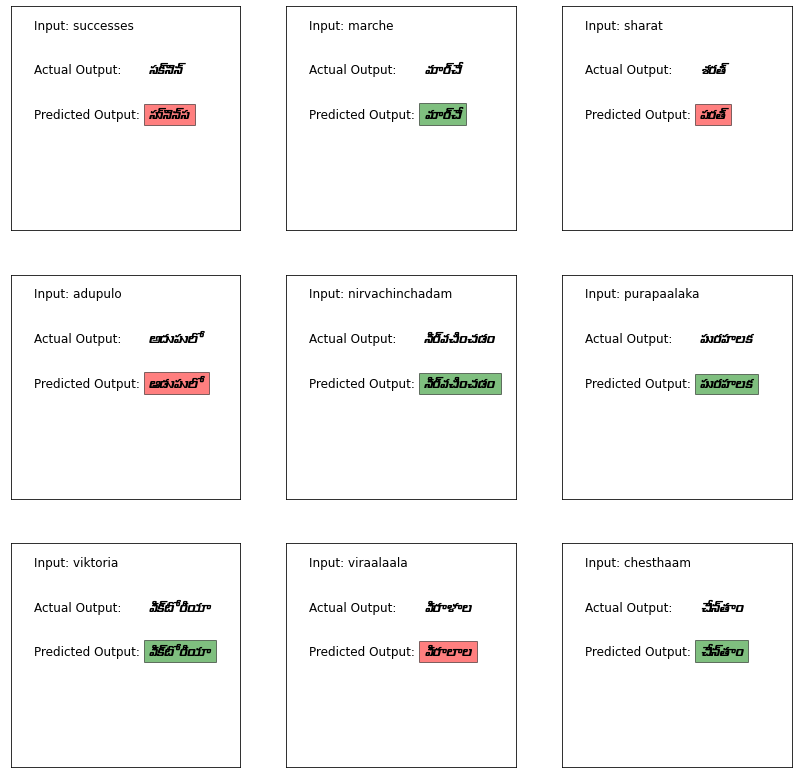

In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties as FontProperties


fig,axs = plt.subplots(3,3,figsize=(14,14))
font_new =  fontp(fname='telugu.ttf')
font_dict = {'fontsize':50}

for x in axs:
  for ax in x:
    ax.set_xticks([])
    ax.set_yticks([])

idx = [i for i in range(s2s.encoder_test.shape[0])]
random.shuffle(idx)
idx = idx[:9]
count = 0

for p in range(axs.shape[0]):
  for q in range(axs.shape[1]):
    i = idx[count]
    pred = model([np.expand_dims(s2s.encoder_test[i],0),np.expand_dims(s2s.decoder_test[i],0)])
    input = re.sub('\t|\n','',''.join([s2s.inv_input_token_index[s2s.encoder_test[i][j]] for j in range(s2s.max_length_x)]))
    actual_out = re.sub('\t|\n','',''.join([s2s.inv_target_token_index[s2s.decoder_test[i][j]] for j in range(s2s.max_length_y)]))
    predicted_out = re.sub('\t|\n','',''.join(s2s.inv_target_token_index[np.argmax(pred[0][j])] for j in range(s2s.max_length_y)))

    axs[p,q].text(0.1, 0.9, "Input: "+input, fontsize = 12)
    axs[p,q].text(0.1, 0.7, "Actual Output: ", fontsize = 12)
    axs[p,q].text(0.6, 0.7, actual_out,fontdict=font_dict,fontproperties=font_new)
    axs[p,q].text(0.1, 0.5, "Predicted Output: ", fontsize = 12)
    if actual_out == predicted_out:
      axs[p,q].text(0.6, 0.5, predicted_out,fontsize=30, bbox = {'facecolor':'green','pad':5,"alpha":0.5},fontproperties=font_new)
    else:
      axs[p,q].text(0.6, 0.5, predicted_out,fontsize=30, bbox = {'facecolor':'red','pad':5,"alpha":0.5},fontproperties=font_new)

    count += 1
